In [1]:
#pip install min-dalle
# Step 2 - Importing Libraries
from moviepy.editor import *
from PIL import Image
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,pipeline
import gradio as gr
import torch
from huggingface_hub import snapshot_download
from PIL import Image
import torch
from PIL import Image, ImageDraw, ImageFont
import textwrap
from mutagen.mp3 import MP3
# to speech conversion
from gtts import gTTS
from pydub import AudioSegment
from os import getcwd
import glob
import nltk
import subprocess
from IPython.display import display, update_display
from min_dalle import MinDalle
nltk.download('punkt')
description = " Video Story Generator with Audio \n PS:  Generation of video by using Artifical Intellingence by dalle-mini and distilbart and gtss "
title = "Video Story Generator with Audio by using dalle-mini and distilbart and gtss  "

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Analsis of GPU usage
def log_gpu_memory():
    print(subprocess.check_output('nvidia-smi').decode('utf-8'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_gpu = True if torch.cuda.is_available() else False
# We check our initial status of our GPU memory
if use_gpu == True : log_gpu_memory() 
temp='''
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    15W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
'''

cuda:0
Tue Aug 30 13:31:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   43C    P0    25W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [3]:
#Loading Models
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")
dtype = "float16" #@param ["float32", "float16", "bfloat16"]
model_dalle = MinDalle(
    dtype=getattr(torch, dtype),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    is_mega=True, 
    is_reusable=True
)

using device cuda
intializing TextTokenizer
initializing DalleBartEncoder
initializing DalleBartDecoder
initializing VQGanDetokenizer


In [4]:
# We cheeck how much memory we have after load all models
if use_gpu == True : log_gpu_memory() 

Tue Aug 30 13:32:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |   6213MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import gc
def wipe_memory():
    torch.cuda.empty_cache() 
    gc.collect()

In [8]:
def generate_image(text):   
    text=text
    progressive_outputs = True #@param {type:"boolean"}
    seamless = False #@param {type:"boolean"}
    grid_size = 1 #@param {type:"integer"}
    temperature = 1 #@param {type:"slider", min:0.01, max:16, step:0.01}
    supercondition_factor = 16 #@param {type:"number"}
    top_k = 128 #@param {type:"integer"}
    image_stream = model_dalle.generate_image_stream(
        text=text,
        seed=-1,
        grid_size=grid_size,
        progressive_outputs=progressive_outputs,
        is_seamless=seamless,
        temperature=temperature,
        top_k=int(top_k),
        supercondition_factor=float(supercondition_factor)
    )

    is_first = True
    for image in image_stream:
        #display_image = display if is_first else update_display
        #display_image(image, display_id=1)
        is_first = False
    return image

In [11]:
def main(text):
    inputs = tokenizer(text=text, 
                    max_length=1024, 
                    truncation=True,
                    return_tensors="pt") 
    summary_ids = model.generate(inputs["input_ids"])
    summary = tokenizer.batch_decode(summary_ids, 
                                  skip_special_tokens=True, 
                                  clean_up_tokenization_spaces=False)
    plot = list(summary[0].split('.'))

    generated_images = []
    for senten in plot[:-1]:
        if use_gpu == True : 
            torch.cuda.empty_cache() 
            gc.collect()
        image= generate_image(senten)
        print('For the sentence:\n',senten)
        display(image)
        #if use_gpu == True : log_gpu_memory() 
        generated_images.append(image)

    # Step 4- Creation of the subtitles
    sentences =plot[:-1]
    num_sentences=len(sentences)
    assert len(generated_images) == len(sentences) , print('Something is wrong')
    #We can generate our list of subtitles
    from nltk import tokenize
    c = 0
    sub_names = []
    for k in range(len(generated_images)): 
        subtitles=tokenize.sent_tokenize(sentences[k])
        sub_names.append(subtitles)

    # Step 5- Adding Subtitles to the Images
    def draw_multiple_line_text(image, text, font, text_color, text_start_height):
        draw = ImageDraw.Draw(image)
        image_width, image_height = image.size
        y_text = text_start_height
        lines = textwrap.wrap(text, width=40)
        for line in lines:
            line_width, line_height = font.getsize(line)
            draw.text(((image_width - line_width) / 2, y_text), 
                      line, font=font, fill=text_color)
            y_text += line_height

    def add_text_to_img(text1,image_input):
        '''
        Testing draw_multiple_line_text
        '''
        image =image_input
        fontsize = 13  # starting font size
        path_font="Roboto-Regular.ttf"
        font = ImageFont.truetype(path_font, fontsize)
        text_color = (255,255,0)
        text_start_height = 200
        draw_multiple_line_text(image, text1, font, text_color, text_start_height)
        return image

    generated_images_sub = []
    for k in range(len(generated_images)): 
        imagenes = generated_images[k].copy()
        text_to_add=sub_names[k][0]
        result=add_text_to_img(text_to_add,imagenes)
        generated_images_sub.append(result)

    # Step  7 - Creation of audio 
    c = 0
    mp3_names = []
    mp3_lengths = []
    for k in range(len(generated_images)):
        text_to_add=sub_names[k][0]
        print(text_to_add)
        f_name = 'audio_'+str(c)+'.mp3'
        mp3_names.append(f_name)
        # The text that you want to convert to audio
        mytext = text_to_add
        # Language in which you want to convert
        language = 'en'
        # Passing the text and language to the engine,
        # here we have marked slow=False. Which tells
        # the module that the converted audio should
        # have a high speed
        myobj = gTTS(text=mytext, lang=language, slow=False)
        # Saving the converted audio in a mp3 file named
        sound_file=f_name
        myobj.save(sound_file)
        audio = MP3(sound_file)
        duration=audio.info.length
        mp3_lengths.append(duration)
        print(audio.info.length)
        c+=1


    # Step 8 - Merge audio files
    cwd = (getcwd()).replace(chr(92), '/')
    #export_path = f'{cwd}/result.mp3'
    export_path ='result.mp3'
    MP3_FILES = glob.glob(pathname=f'{cwd}/*.mp3', recursive=True)
    silence = AudioSegment.silent(duration=500)
    full_audio = AudioSegment.empty()    # this will accumulate the entire mp3 audios
    for n, mp3_file in enumerate(mp3_names):
        mp3_file = mp3_file.replace(chr(92), '/')
        print(n, mp3_file)
        # Load the current mp3 into `audio_segment`
        audio_segment = AudioSegment.from_mp3(mp3_file)
        # Just accumulate the new `audio_segment` + `silence`
        full_audio += audio_segment + silence
        print('Merging ', n)
    # The loop will exit once all files in the list have been used
    # Then export    
    full_audio.export(export_path, format='mp3')
    print('\ndone!')

    # Step 9 - Creation of the video with adjusted times of the sound
    c = 0
    file_names = []
    for img in generated_images_sub:
        f_name = 'img_'+str(c)+'.jpg'
        file_names.append(f_name)
        img = img.save(f_name)
        c+=1
    print(file_names)
    clips=[]
    d=0
    for m in file_names:
        duration=mp3_lengths[d]
        print(d,duration)
        clips.append(ImageClip(m).set_duration(duration+0.5))
        d+=1
    concat_clip = concatenate_videoclips(clips, method="compose")
    concat_clip.write_videofile("result_new.mp4", fps=24)

    # Step 10 - Merge Video + Audio
    movie_name = 'result_new.mp4'
    export_path='result.mp3'
    movie_final= 'result_final.mp4'
    def combine_audio(vidname, audname, outname, fps=60): 
        import moviepy.editor as mpe
        my_clip = mpe.VideoFileClip(vidname)
        audio_background = mpe.AudioFileClip(audname)
        final_clip = my_clip.set_audio(audio_background)
        final_clip.write_videofile(outname,fps=fps)
    combine_audio(movie_name, export_path, movie_final) # create a new file

In [16]:
text='Once, there was a girl called Laura who went to the supermarket to buy the ingredients to make a cake. Because today is her birthday and her friends come to her house and help her to prepare the cake.'

For the sentence:
  Once, Laura went to the supermarket to buy the ingredients to make a cake 


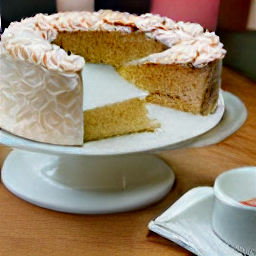

For the sentence:
  Her friends come to her house and help her to prepare the cake 


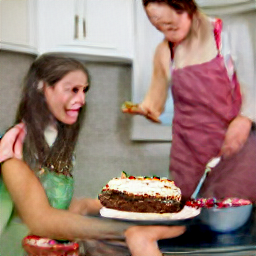

For the sentence:
  Because today is her birthday, she has friends help her prepare it for her birthday 


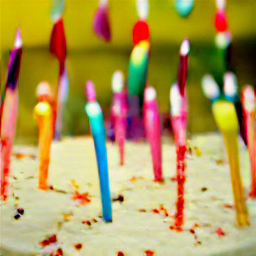

For the sentence:
  Laura's friends come and help prepare her to make her birthday cake 


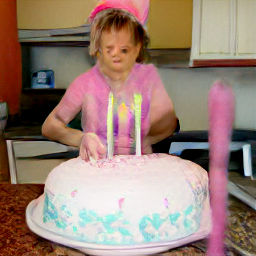

 Once, Laura went to the supermarket to buy the ingredients to make a cake
5.256
 Her friends come to her house and help her to prepare the cake
4.152
 Because today is her birthday, she has friends help her prepare it for her birthday
5.544
 Laura's friends come and help prepare her to make her birthday cake
4.536
0 audio_0.mp3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Merging  0
1 audio_1.

100%|██████████| 516/516 [00:00<00:00, 1379.61it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: result_new.mp4 



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 476/476 [00:00<00:00, 1333.41it/s]

[MoviePy] Done.
[MoviePy] Writing video result_final.mp4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|█████████▉| 1290/1291 [00:00<00:00, 1846.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_final.mp4 



In [17]:
main(text)

In [18]:
from IPython.display import HTML
from base64 import b64encode
import os
# Show video
mp4 = open('result_final.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [14]:
def get_output_video(text):
    main(text=text)
    return 'result_final.mp4'
text ='Once, there was a girl called Laura who went to the supermarket to buy the ingredients to make a cake. Because today is her birthday and her friends come to her house and help her to prepare the cake.'
demo = gr.Blocks()
with demo:
    gr.Markdown("# Video Generator from stories with Artificial Intelligence")
    gr.Markdown("A story can be input by user. The story is summarized using DistillBART model. Then, then it is generated the images by using Dalle-mini and created the subtitles and audio gtts. These are generated as a video.")
    with gr.Row():
        # Left column (inputs)
        with gr.Column():         
            input_start_text = gr.Textbox(value=text, label="Type your story here, for now a sample story is added already!")
            with gr.Row():
                button_gen_video = gr.Button("Generate Video")
        # Right column (outputs)
        with gr.Column():
            output_interpolation = gr.Video(label="Generated Video")
    gr.Markdown("<h3>Future Works </h3>")
    gr.Markdown("This program text-to-video AI software generating videos from any prompt! AI software to build an art gallery. The future version will use Dalle-2 For more info visit [ruslanmv.com](https://ruslanmv.com/) ")
    button_gen_video.click(fn=get_output_video, inputs=input_start_text, outputs=output_interpolation)

In [15]:
demo.launch(inline=False,debug=True)

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/text2video/lib/python3.8/site-packages/gradio/routes.py", line 248, in run_predict
    output = await app.blocks.process_api(
  File "/home/ec2-user/anaconda3/envs/text2video/lib/python3.8/site-packages/gradio/blocks.py", line 643, in process_api
    predictions, duration = await self.call_function(fn_index, processed_input)
  File "/home/ec2-user/anaconda3/envs/text2video/lib/python3.8/site-packages/gradio/blocks.py", line 558, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/home/ec2-user/anaconda3/envs/text2video/lib/python3.8/site-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/home/ec2-user/anaconda3/envs/text2video/lib/python3.8/site-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/home/ec2-user/anaconda3/envs/text2video/lib/python3.8/site-packages/any

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f98f710d0a0>, 'http://127.0.0.1:7860/', None)

In [ ]:
#demo.close()